In [19]:
import frame_video_convert
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torchvision
from torchvision.models import vgg16
from PIL import Image
from torchvision.models.segmentation import fcn_resnet50

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
frame_video_convert.video_to_image_seq("my_data/myVideo.mp4", "my_data/myVideo_frames/")

converting video to frames...
total frames:  199


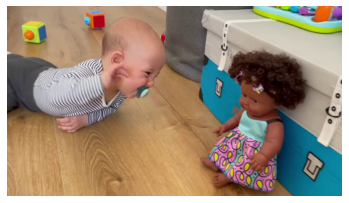

In [21]:
frame1 = cv2.imread('my_data/myVideo_frames/0000.jpg')
plt.imshow(cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB))
_ = plt.axis('off')

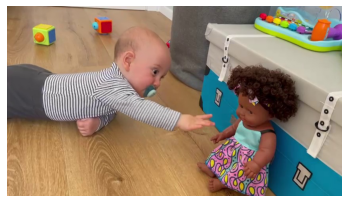

In [22]:
frame2 = cv2.imread('my_data/myVideo_frames/0100.jpg')
plt.imshow(cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB))
_ = plt.axis('off')

In [23]:
seg_model = fcn_resnet50(pretrained=True)
seg_model.eval()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
seg_model = seg_model.to(device)

preprocess = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [24]:
def mask_person(frame_path):
    frame = Image.open(frame_path)
    frame_tensor = preprocess(frame).unsqueeze(0).to(device)
    with torch.no_grad():
        output = seg_model(frame_tensor)['out'][0]
    output_predictions = output.argmax(0)

    mask = torch.zeros_like(output_predictions).float().to(device)
    mask[output_predictions == 15] = 1
    masked_person = frame * mask.unsqueeze(2).byte().cpu().numpy()

    return masked_person

In [25]:
import glob

masked_person_frames = []
for frame_path in glob.glob('my_data/myVideo_frames/*.jpg'):
    masked_person_frames.append(mask_person(frame_path))

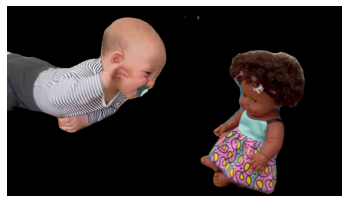

In [26]:
plt.imshow(masked_person_frames[0])
_ = plt.axis('off')

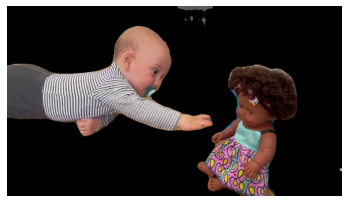

In [27]:
plt.imshow(masked_person_frames[100])
_ = plt.axis('off')

# Segmentation from the T-rex video

In [28]:
frame_video_convert.video_to_image_seq("my_data/T-RexVideo.mp4", "my_data/T-rex_frames/")

converting video to frames...
total frames:  140


In [29]:
def mask_dino(frame_path):
    frame = cv2.imread(frame_path)
    
    u_green = np.array([10, 215, 10])
    l_green = np.array([0, 195, 0])

    mask = cv2.inRange(frame, l_green, u_green)
    res = cv2.bitwise_and(frame, frame, mask = mask)

    f = frame - res
    return f

In [30]:
import glob

masked_dino_frames = []
for frame_path in glob.glob('my_data/T-rex_frames/*.jpg'):
    masked_dino_frames.append(mask_dino(frame_path))

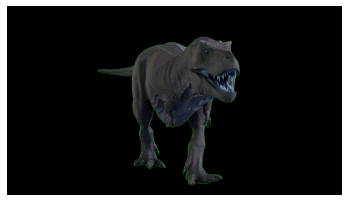

In [31]:
plt.imshow(masked_dino_frames[0])
_ = plt.axis('off')

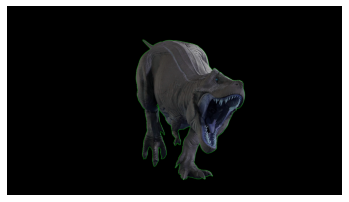

In [32]:
plt.imshow(masked_dino_frames[100])
_ = plt.axis('off')

In [33]:
print(masked_person_frames[0].shape)
print(masked_dino_frames[0].shape)

(480, 848, 3)
(1440, 2560, 3)


In [48]:
def stich():
    stiched_frames = []
    i = 0
    for (frame_dino, frame_person) in zip(masked_dino_frames, masked_person_frames):
        frame_person = cv2.cvtColor(frame_person, cv2.COLOR_BGR2RGB)
        scale_percent = 40 # percent of original size
        width = int(frame_dino.shape[1] * scale_percent / 100)
        height = int(frame_dino.shape[0] * scale_percent / 100)
        dim = (width, height)

        # resize dino
        resized_dino = cv2.resize(frame_dino, dim, interpolation = cv2.INTER_AREA)

        dino_x_offset = 600
        dino_y_offset = 190

        person_x_offset = 0
        person_y_offset = 720

        bliss = cv2.imread('my_data/bliss_bg.jpg')

        np.copyto(bliss[dino_y_offset:dino_y_offset+resized_dino.shape[0], dino_x_offset:dino_x_offset+resized_dino.shape[1]], resized_dino, where=resized_dino[:,:]!=0)
        np.copyto(bliss[person_y_offset:person_y_offset+frame_person.shape[0], person_x_offset:person_x_offset+frame_person.shape[1]], frame_person, where=frame_person[:,:]!=0)

        height, width, layers = bliss.shape
        bliss = cv2.resize(bliss, (width // 2, height // 2))
        bliss = cv2.resize(bliss, (width, height))

        cv2.imwrite("../output/stiched_frames/{}.jpg".format(str(i).zfill(4)), bliss)
        i += 1
        

In [49]:
stich()

In [50]:
frame_video_convert.image_seq_to_video("../output/stiched_frames/", "../output/video.mp4", 30)

(1920, 1200)
writing video...
saved video @  ../output/video.mp4
